# Explorar las ofertas relámpago, ¿qué insights puedes generar?

Descripción
En conjunto con el desafío te compartimos un archivo llamado ofertas_relampago.csv el
cual posee información de los resultados de ofertas del tipo relampago para un periodo de
tiempo y un país determinado.

Es decir, son ofertas que tienen una duración definida de algunas horas y un porcentaje de
unidades (stock) comprometidas.

El objetivo de este desafío es hacer un EDA sobre estos datos buscando insights sobre este
tipo de ofertas. Las columnas del dataset son autoexplicativas pero puedes preguntarnos cualquier duda.

El entregable de este desafío es una Jupyter notebook con el EDA.

In [1]:
# bibliotecas
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [2]:
# Importação de tabelas
ofertas_relampago = pd.read_csv('ofertas_relampago.csv')
ofertas_relampago

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48741,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,15,9,16.28,6.0,NaN,none,HOME&DECOR,HOME & INDUSTRY,MLM-CHRISTMAS_LIGHTS
48742,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-DECORATIVE_PAINTINGS
48743,2021-06-19,2021-06-19 07:00:00+00:00,2021-06-19 13:00:03+00:00,lightning_deal,5,3,16.62,2.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS
48744,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:00+00:00,lightning_deal,5,1,38.79,4.0,NaN,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS


• Base bronze;
• Tabela Agregada;

### Análise Descritiva da Variáveis

In [3]:
# informações sobre a tabela
ofertas_relampago.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48746 entries, 0 to 48745
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OFFER_START_DATE           48746 non-null  object 
 1   OFFER_START_DTTM           48746 non-null  object 
 2   OFFER_FINISH_DTTM          48746 non-null  object 
 3   OFFER_TYPE                 48746 non-null  object 
 4   INVOLVED_STOCK             48746 non-null  int64  
 5   REMAINING_STOCK_AFTER_END  48746 non-null  int64  
 6   SOLD_AMOUNT                24579 non-null  float64
 7   SOLD_QUANTITY              24579 non-null  float64
 8   ORIGIN                     11316 non-null  object 
 9   SHIPPING_PAYMENT_TYPE      48746 non-null  object 
 10  DOM_DOMAIN_AGG1            48746 non-null  object 
 11  VERTICAL                   48746 non-null  object 
 12  DOMAIN_ID                  48746 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usag

Uma etapa importante aqui é entender a relevância desses valores nulos dentro da base e quais tratamentos devem ser aplicados
para mitigar os efeitos no modelo, ou se não são valores tão relevantes a ponto de impactar a análise.

In [4]:
# análise descritiva multivariada dos valores da tabela
data_describe = ofertas_relampago.describe(exclude=[object]).T
pd.options.display.float_format = '{:20,.2f}'.format                  #supressão de notação científica
data_describe

,count,mean,std,min,25%,50%,75%,max
INVOLVED_STOCK,"48,746.00",35.01,206.76,1.00,5.00,10.00,15.00,"9,000.00"
REMAINING_STOCK_AFTER_END,"48,746.00",30.57,195.81,-192.00,4.00,8.00,15.00,"8,635.00"
SOLD_AMOUNT,"24,579.00",51.21,175.25,0.28,5.73,12.42,30.93,"4,836.57"
SOLD_QUANTITY,"24,579.00",10.85,45.48,1.00,1.00,3.00,6.00,"1,646.00"


    • INVOLVED_STOCK: o volume de disponibilidade do produto;
    • REMAINING_STOCK_AFTER_END: o volume de disponibilidade do produto após a oferta;    
    • SOLD_AMOUNT: receita gerada pela oferta;    
    • SOLD_QUANTITY: volume vendido pela oferta - diferença da disponibilidade anterior e posterior da oferta;

    • A diferença entre os valores de máximos e terceiro quartis é alta, o que pode já ser um indicador de outliers;
    • Na variável REMAINING_STOCK_AFTER_END, o valor de mínimo está muito distante do primeiro quartil, o que pode ser um indicador de outlier para esta variável;
    • O desvio padrão também está bem alto nas quatro variáveis o que indica que os valores estão bastante dispersos em torno da média, ou seja, a existência de outliers entre primeiro e terceiro quartil é possível;

In [5]:
# análise descritiva dos objetos tabela
ofertas_relampago.describe(exclude=[np.number]).T

,count,unique,top,freq
OFFER_START_DATE,48746,61,2021-07-30,1300
OFFER_START_DTTM,48746,783,2021-07-30 13:00:00+00:00,414
OFFER_FINISH_DTTM,48746,7578,2021-07-06 13:00:01+00:00,77
OFFER_TYPE,48746,1,lightning_deal,48746
ORIGIN,11316,1,A,11316
SHIPPING_PAYMENT_TYPE,48746,2,free_shipping,26658
DOM_DOMAIN_AGG1,48746,36,HOME&DECOR,6742
VERTICAL,48746,9,APP & SPORTS,13241
DOMAIN_ID,48746,1266,MLM-SURGICAL_AND_INDUSTRIAL_MASKS,1759


    • OFFER_START_DATE: marca de início da oferta;
    • OFFER_START_DTTM: datetime da marca do início da oferta;    
    • OFFER_FINISH_DTTM: datetime da marca do fim da oferta;    
    • OFFER_TYPE: categoria da oferta;
    • ORIGIN: flag de rastreio da oferta;
    • SHIPPING_PAYMENT_TYPE: fee;
    • DOM_DOMAIN_AGG1: domínio dos produtos - categoria;
    • VERTICAL: domínio dos produtos - categoria macro;
    • DOMAIN_ID: domínio dos produtos - sub categoria;

    • O domínio de maior relevância e volume na base é o MLM-SURGICAL_AND_INDUSTRIAL_MASKS, levando em consideração o período que a base abrange que condiz com o período durante a pandemia, pode ser que as máscaras sejam também o item de maior volume de vendas;
    • Um bom começo seria compreender como os domínios de relacionam e, de acordo com a necessidade estratégica, escolher o que melhor responde as perguntas do negócio;
    • Um ponto de atenção é para a data de início e final de possível maior volume de vendas das ofertas oferecidas:
        > quais ofertas estavam onsite neste dia?
        > quais domínios mais vendidos?
        > existe uma sazonalidade/ciclos/tendência?;

### Distribuição

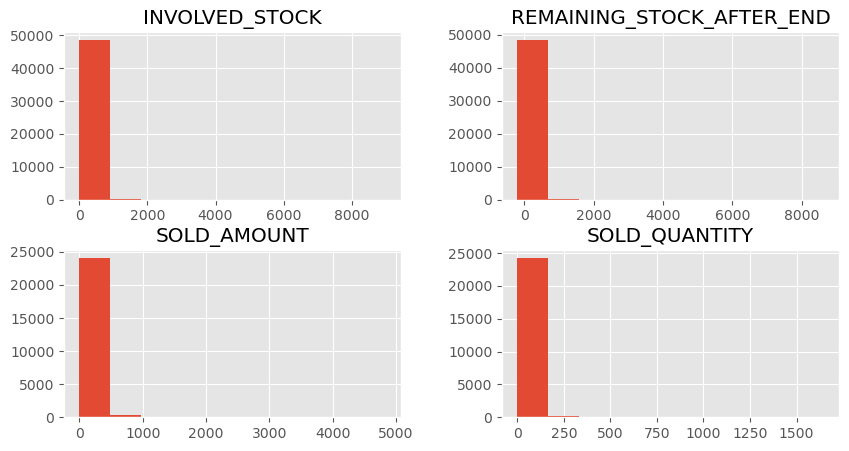

In [6]:
# vamos selecionar as colunas
ofertas = ofertas_relampago.loc[:,[  'INVOLVED_STOCK',  'REMAINING_STOCK_AFTER_END', 'SOLD_AMOUNT',
                         'SOLD_QUANTITY']]

# na sequancia, vamos entender a distribuição
_,ax = plt.subplots(figsize=(10,5))
ofertas.hist(ax=ax)
plt.show();

    • A assimetria à direita dos histogramas já aparece como um indicador de confirmação de que os outliers estão mesmo nos valores mais altos e que o importante agora é investigar os fatores que levaram a essas anomalias e se devem ou não serem descartadas;
    • Próximo passo é estudar os picos de distribuição e dispersão da série e conhecer as informações contidas neles;

### Estudo do comportamento dos Dados

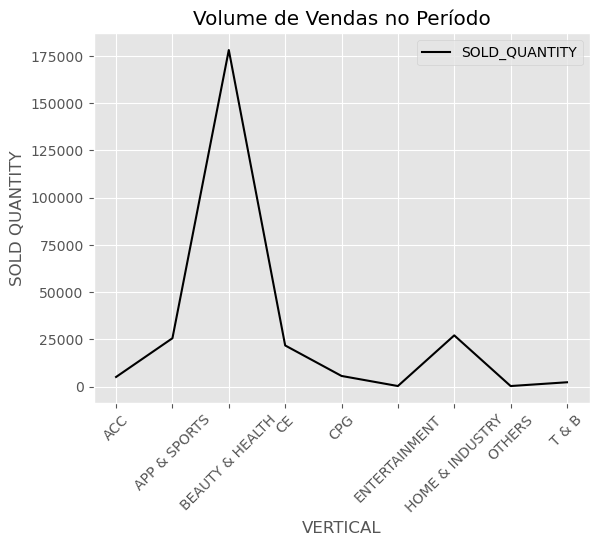

In [7]:
# Volume vendido por setor vertical
oft1 = ofertas_relampago.loc[:,['VERTICAL','SOLD_QUANTITY']]
oft1 = oft1.groupby(['VERTICAL']).sum()
oft1.plot(label='Volume', color = 'k')
plt.ylabel('SOLD QUANTITY')
plt.xlabel('VERTICAL')
plt.title('Volume de Vendas no Período')
plt.xticks(rotation=45)
plt.plot(figsize=(14,12))
plt.legend()
plt.show()

    • Beleza e Saúde são os setores que mais de destacam em volumes de vendas, apesar do valor que mais apareceu na coluna foi o setor de APP & Sports;
    • A coluna VERTICAL foi escolhida como foco de setores por possuir o menor volume de valores únicos o que possibilita uma análise macro, podendo ser alterada a qualquer momento afim de aumentar a granularidade;

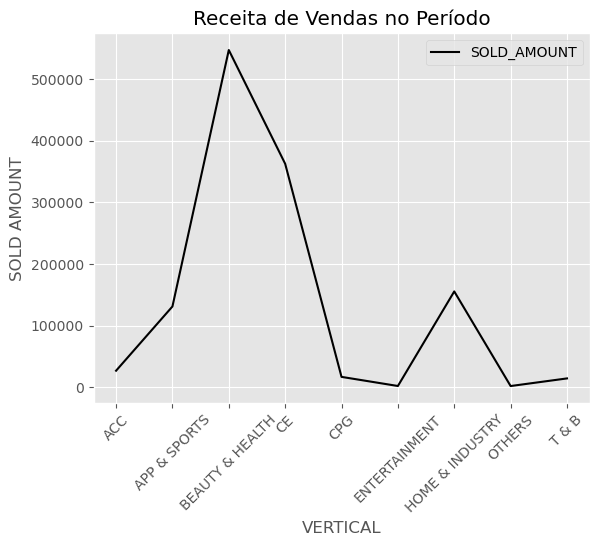

In [8]:
# Receita gerada por setor vertical
oft = ofertas_relampago.loc[:,['VERTICAL','SOLD_AMOUNT']]
oft = oft.groupby(['VERTICAL']).sum()
oft.plot(label='Volume', color = 'k')
plt.ylabel('SOLD AMOUNT')
plt.xlabel('VERTICAL')
plt.title('Receita de Vendas no Período')
plt.xticks(rotation=45)
plt.plot(figsize=(14,12))
plt.legend()
plt.show()

    • O setor de CE, apesar de possuir um menor volume de vendas, foi a segunda maior receita gerada dentro do período de ofertas analisado;
    • Para este caso, podemos clusterizar os setores, em um nível de granularidade menor para entender onde se encontram as maiores oportunidades e as de menor aproveitamento;
    • Como os outliers representam apenas um alto volumes de vendas com títulos promocionais, não necessariamente devem ser descartados;

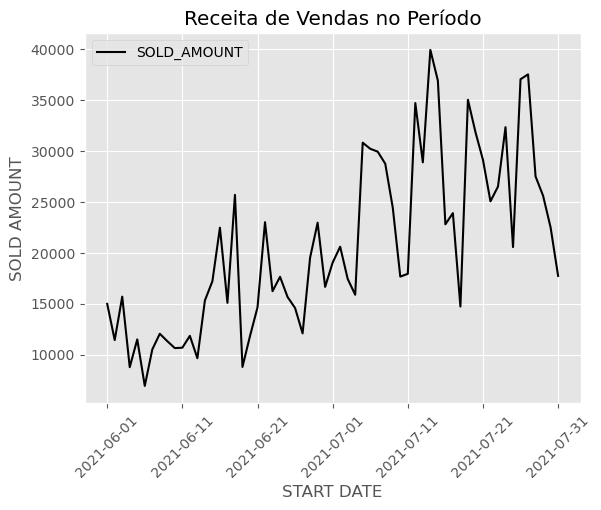

In [9]:
# Vejamos assim a receita ao longo do período das ofertas
oft = ofertas_relampago.loc[:,['OFFER_START_DATE','SOLD_AMOUNT']]
oft = oft.groupby(['OFFER_START_DATE']).sum()
oft.plot(label='Volume', color = 'k')
plt.ylabel('SOLD AMOUNT')
plt.xlabel('START DATE')
plt.title('Receita de Vendas no Período')
plt.xticks(rotation=45)
plt.plot(figsize=(14,12))
plt.legend()
plt.show()

###  Série Temporal - ARIMA

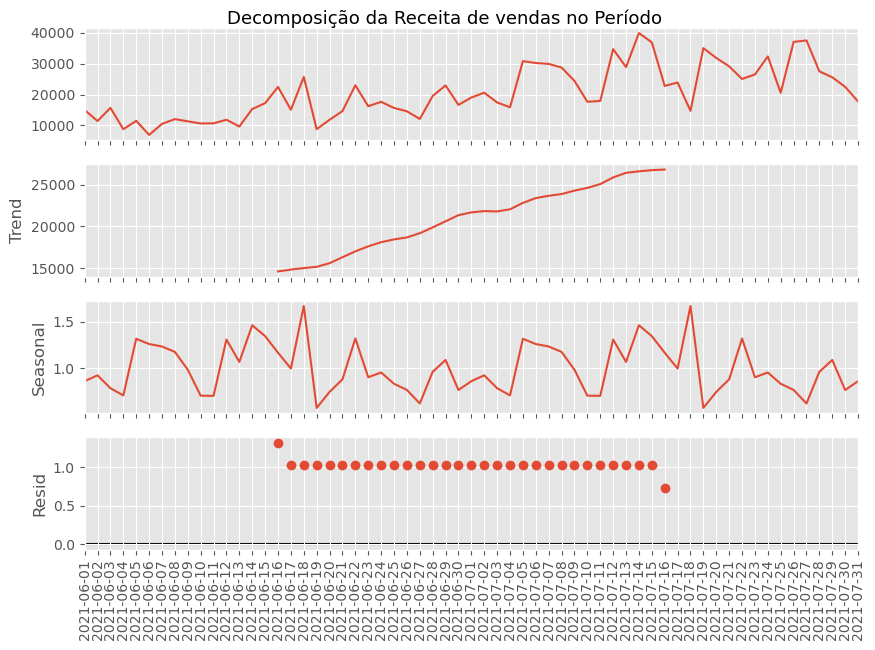

In [10]:
# Decomposição pelo modelo Multiplicativo da série de vendas ao longo do tempo
decom = seasonal_decompose(oft, model='multiplicative', period=30) #decomposição mensal
fig = decom.plot()
fig.set_size_inches(10, 6)
fig.suptitle('Decomposição da Receita de vendas no Período', fontsize=13)
plt.subplots_adjust(top=0.95)
plt.xticks(rotation=90)
plt.show()

    • A tendência da série no mostra um comportamento crescente o que indica uma maior adesão ao modelo de ofertas com o tempo, o que é um bom sinal para que as ofertas continuem e possam ser expandidas para outros produtos/categorias, o que também é um indicativo de não estacionariedade da série temporal;
    • É possível ver a sazonalidade espaçada com intervalos regulares que repetem ao longo do tmepo, como por exemplo o período de alta de vendas entre os dias 04 e 10, quando os estoques, das categorias mais vendidas podem ser aumentados ou o processo de logística pode ser otimizado;
    • O período foi escolhido a fim de captar a menor distribuição dos resíduos, ou seja, um período com menos flutuações na série, é notável a irregularidade que os outliers causaram nos resíduos da série, porém como não foi identificada nenhuma incomformidade com a capitação e preparação dos dados, por serem ruídos brancos eles serão mantidos na análise;

In [11]:
# Teste ADF para estacionariedade da série - Dickey-Fuller Aumentado
# H0: a série não é estacionária, ou seja, tem um componente dependentedo tempo
# H1: rejetia a hipótese nula, ou seja, a série é estacionária e não depende do tempo.

# extrair os valores
O = oft.SOLD_AMOUNT.values

# aplicar ADF e imprimir o resultado
result = adfuller(O)
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
    print('\t{}: {:.4f}'.format(key, value))

Teste Estatístico: -1.1330
Valor-p: 0.7017
Valores Críticos:
	1%: -3.5577
	5%: -2.9168
	10%: -2.5962


Com p valor menor que um nível de confiança que 95%, ou seja p-value > 0.05, não rejeitamos a hipótese nula e assim determinamos que a série não é estacionária. Por isso, a modelagem ARIMA foi escolhida, pois conta com o componente de diferenciação (remove a tendência) que trasforma a série não estacionária em estacionária. 

### Definir os valores de p, d, e q

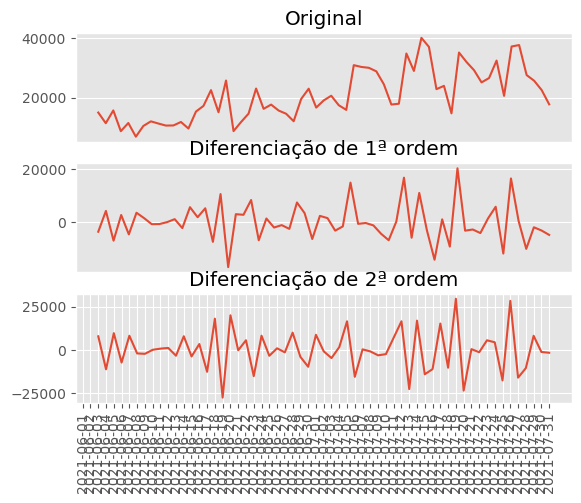

In [12]:
# d
# Original
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(oft.SOLD_AMOUNT); ax1.set_title('Original'); ax1.axes.xaxis.set_visible(False)

# Primeira Ordem
ax2.plot(oft.SOLD_AMOUNT.diff()); ax2.set_title('Diferenciação de 1ª ordem'); ax2.axes.xaxis.set_visible(False)

# Segunda Ordem
ax3.plot(oft.SOLD_AMOUNT.diff().diff()); ax3.set_title('Diferenciação de 2ª ordem')
plt.xticks(rotation=90)
plt.show()

É possível observar que não há um aumento significativo de ruído entre a primeira e a segunda ordem do termo de diferenciação, podemos então, escolher o termo de segunda ordem para a modelagem.

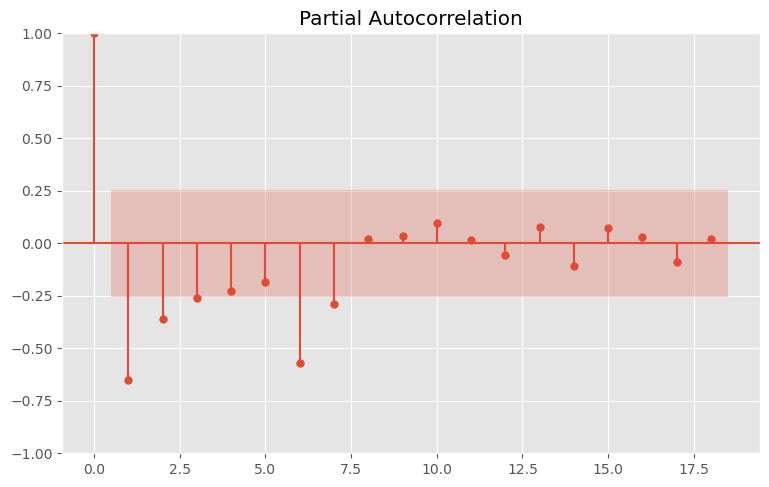

In [13]:
# p
fig2 = plot_pacf(oft.SOLD_AMOUNT.diff().diff().dropna())
fig2.set_size_inches(9, 5)
fig.suptitle('Partial Autocorrelation', fontsize=13)
plt.subplots_adjust(top=0.95)
plt.show()

O teste da autocorrelação nos mostra pelo menos 3 intervalos que estão significativamente fora dos limites, e outros 2 que não ultrapassam os limites de forma significante. Assim, podemos selecionar a ordem de p como 3.

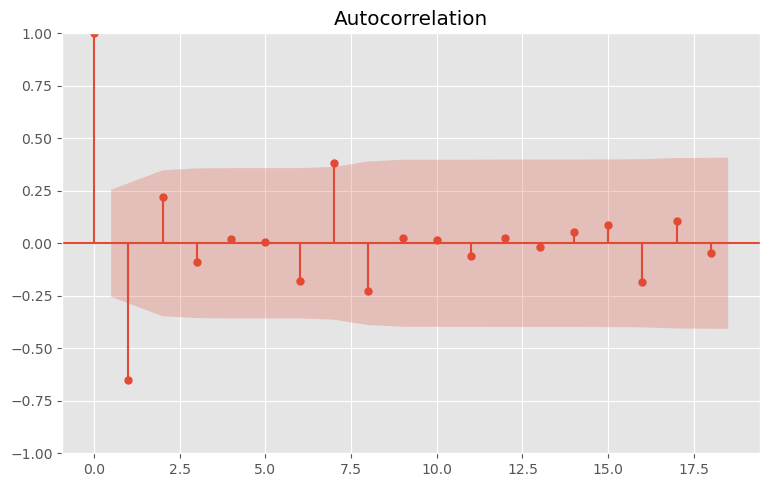

In [14]:
# q
fig3 = plot_acf(oft.SOLD_AMOUNT.diff().diff().dropna())
fig3.set_size_inches(9, 5)
fig.suptitle('Autocorrelation', fontsize=13)
plt.subplots_adjust(top=0.95)
plt.show()

Existem claramente duas das defasagens estão fora do limite de significância, portanto, podemos dizer que o valor ideal do nosso q (MA) é 2.

In [15]:
# Treino e Teste - separamos as últimas 15 observações para testar a acurácia do treino
train = oft[:-15]  
test = oft[-15:]

In [16]:
# Modelagem ARIMA
model = ARIMA(train, order=(3,2,2))
fit = model.fit()

# Previsão - estimação de quinze pontos a frente do período de treino do modelo
forecast = fit.forecast(steps=15)[0]
df_forecast = pd.DataFrame(data={"Forecast": forecast}, index=test.index)

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SOLD_AMOUNT   No. Observations:                   46
Model:                 ARIMA(3, 2, 2)   Log Likelihood                -445.002
Date:                Sun, 25 Feb 2024   AIC                            902.004
Time:                        22:04:04   BIC                            912.709
Sample:                    06-01-2021   HQIC                           905.974
                         - 07-16-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2589      0.329      0.787      0.431      -0.386       0.904
ar.L2         -0.0238      0.253     -0.094      0.925      -0.519       0.471
ar.L3         -0.2964      0.328     -0.903      0.367      -0.940       0.347
ma.L1         -1.8086      0.311     -5.824      0.000      -2.417      -1.200
ma.L2          0.8260      0.332      2.484      0.013       0.174       1.478
sigma2      4.868e+07   4.19e-09   1.16e+16      0.000    4.87e+07    4.87e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.61   Prob(JB):                         0.42
Heteroskedasticity (H):               3.94   Skew:                             0.49
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.91e+31. Standard errors may be unstable.
"""

A busca dos melhores parâtros de ordem do modelo buscam minimizar as pontuaçãoes do Critério de Informação de Akaike e do Critério de Informação Bayesiano, que para este caso, foram as menores encontradas, afim de minimizar as perdas de informações e melhorar o ajuste da predição do modelo.

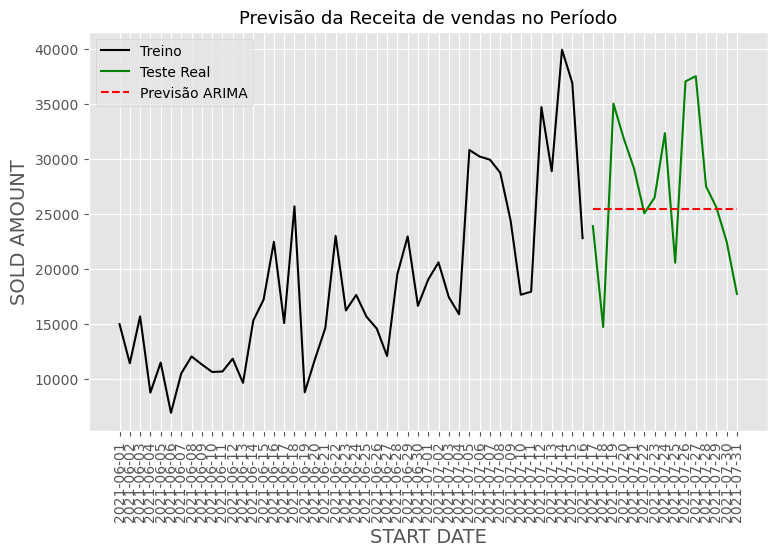

In [17]:
# Visualização
plt.figure(figsize=(8, 5))
plt.plot(train, label="Treino", color='k')
plt.plot(test, label="Teste Real", color='green')
plt.plot(df_forecast, label="Previsão ARIMA", linestyle="--", color='red')
plt.title("Previsão da Receita de vendas no Período", fontsize=13)
plt.xlabel("START DATE", fontsize=14)
plt.ylabel("SOLD AMOUNT", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

    • A captação de receita, apesar de apresentar a tendência de crescimento segundo o modelo, ainda assim é bastante escilante e dependente do fator tempo, seria interessante entender as estratégias utilizados nos pontos de alta na sazonalidade e em quais setores foram utilizados para que possam ser replicadas para outros setores em tempos de baixa captação;
    • A sazonalidade levantra outro ponto interessante a respeito dos períodos de baixa capção, que pode estar relacionado tanto com a falta de estoque dos produtos de determinadas categorias, quanto com a intenção de compra, ou seja, o quanto aquela categoria é representatitava para os clientes e como a estratégia de vendas pode melhorar;
    • A grande vantagem de se poder olhar para frente enquanto se olha para trás é a capacidade de entender os possíveis impactos que novas estratégias podem ter nas vendas, através da incorporação de outras variáveis externas que podem exercer grande influência nas flutuações de receita capturadas pelo modelo;

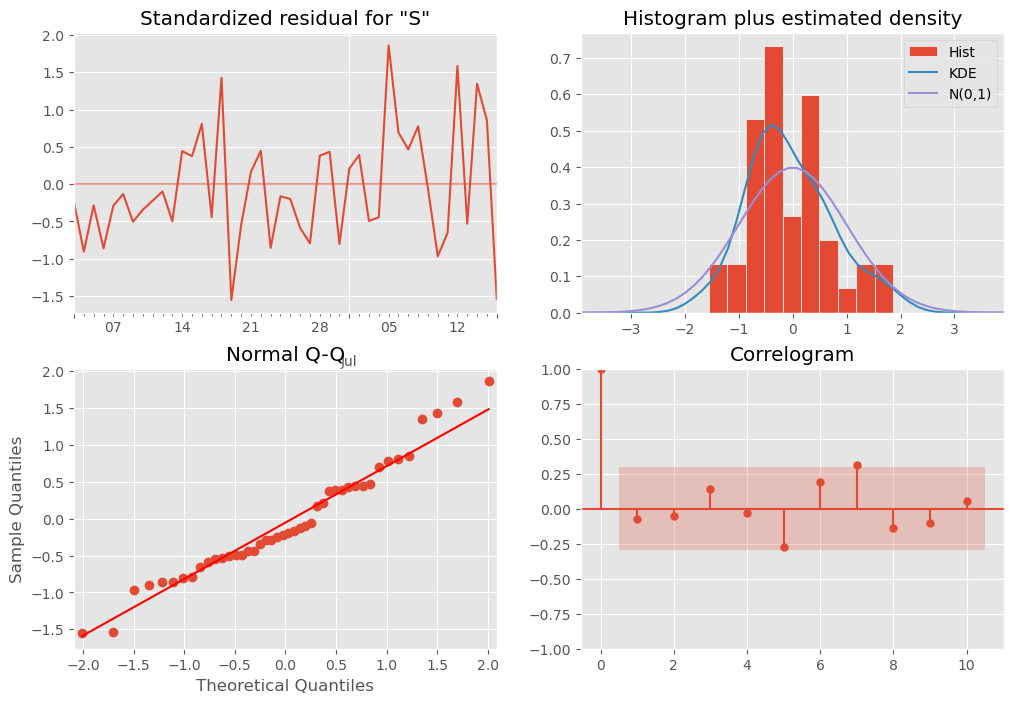

In [18]:
# Diagnóstico do desempenho do modelo
fit.plot_diagnostics(figsize=(12, 8))
plt.show()

    • Standardized residual: este gráfico é uma ferramenta de compreensão de resíduos, para o nosso caso é possível ver que não há um padrão de repetição óbvio dentro dos resíduos, o que é um bom sinal;
    • Histogram plus estimated density: a curva de densidade se aproxima satisfatoriamente da curva normal, sem que haja um aumento significativo da perda de informações quando confrontado com o critério AIC;
    • Normal Q-Q: a grande maioria dos pontos está em torno da linha reta;
    • Correlogram: temos apenas 1 defasagem fora do intervalo de significância, o que nos dá mais de 95% das correlações para defasagem maiores que zero não significativas.